### Questions:
1. Which countries generate the most orders and revenue, and what is the average order value (AOV) by country?
2. How does revenue change over time on a monthly basis?
3. What does the distribution of order amounts look like after winsorizing outliers?
4. Is there a statistically meaningful difference between two groups (e.g., refund rate or mean order amount) across countries?

In [11]:
from pathlib import Path

import numpy as np
import pandas as pd
import plotly.express as px

DATA = Path("../data/processed/analytics_table.parquet")
FIGS = Path("../reports/figures")
FIGS.mkdir(parents=True, exist_ok=True)

def save_fig(fig, path: Path, *, scale: int = 2) -> None:
    """Save a Plotly figure to disk (requires `kaleido`)."""
    path.parent.mkdir(parents=True, exist_ok=True)
    fig.write_image(str(path), scale=scale)

In [12]:
df = pd.read_parquet(DATA)

print("rows:", len(df), "cols:", len(df.columns))
print(df.dtypes.head(15))

missing = df.isna().sum().sort_values(ascending=False).head(10)
print(missing)

rows: 5250 cols: 18
order_id               string[python]
user_id                string[python]
amount                        Float64
quantity                        Int64
created_at        datetime64[ns, UTC]
status                         object
status_clean                   object
amount__isna                     bool
quantity__isna                   bool
date                           object
year                          float64
month                          object
dow                            object
hour                          float64
country                        object
dtype: object
status_clean          551
status                551
hour                  537
dow                   537
date                  537
created_at            537
month                 537
year                  537
quantity              518
amount__is_outlier    496
dtype: int64


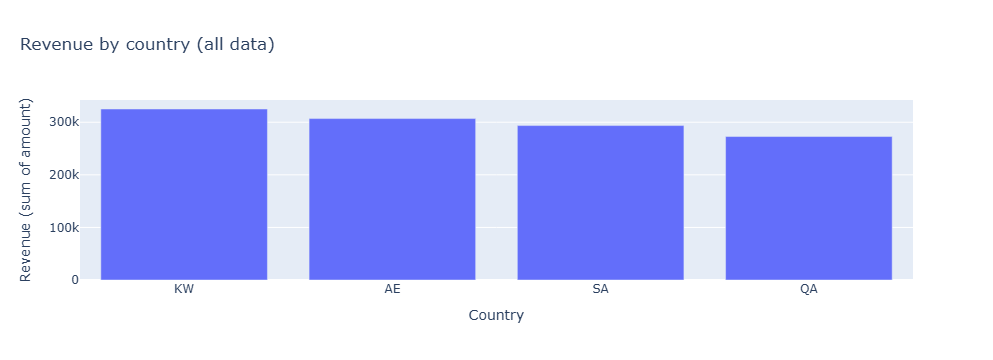

In [13]:
rev = (
    df.groupby("country", dropna=False)
      .agg(
          n=("order_id","size"),
          revenue=("amount","sum"),
          aov=("amount","mean"),
      )
      .reset_index()
      .sort_values("revenue", ascending=False)
)

fig = px.bar(rev, x="country", y="revenue", title="Revenue by country (all data)")
fig.update_layout(title={"x": 0.02})
fig.update_xaxes(title_text="Country")
fig.update_yaxes(title_text="Revenue (sum of amount)")
save_fig(fig, FIGS / "revenue_by_country.png")
fig

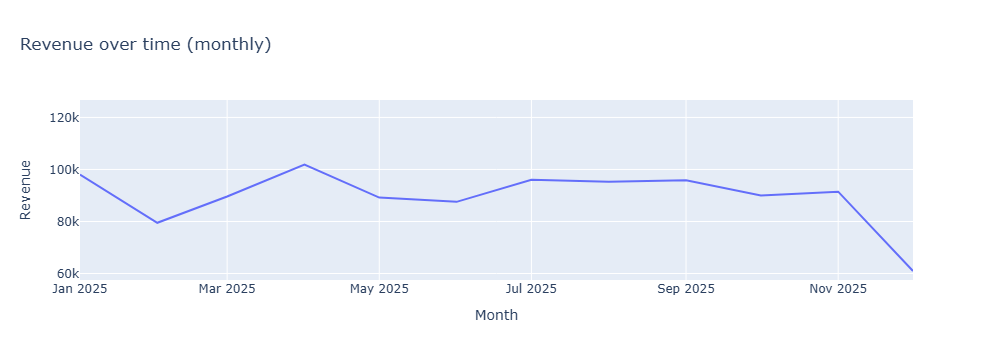

In [14]:
trend = (
    df.groupby("month", dropna=False)
      .agg(n=("order_id","size"), revenue=("amount","sum"))
      .reset_index()
      .sort_values("month")
)

fig = px.line(trend, x="month", y="revenue", title="Revenue over time (monthly)")
fig.update_layout(title={"x": 0.02})
fig.update_xaxes(title_text="Month")
fig.update_yaxes(title_text="Revenue")
save_fig(fig, FIGS / "revenue_trend_monthly.png")
fig

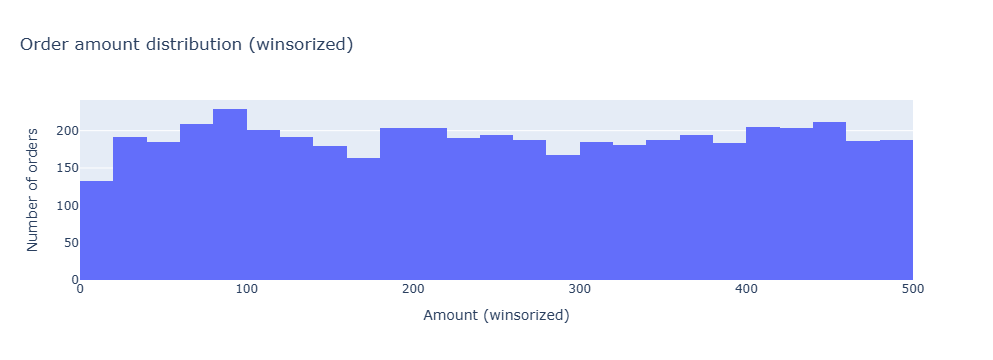

In [15]:
fig = px.histogram(df, x="amount_winsor", nbins=30, title="Order amount distribution (winsorized)")
fig.update_layout(title={"x": 0.02})
fig.update_xaxes(title_text="Amount (winsorized)")
fig.update_yaxes(title_text="Number of orders")
save_fig(fig, FIGS / "amount_hist_winsor.png")
fig

In [16]:
def bootstrap_diff_means(a: pd.Series, b: pd.Series, *, n_boot: int = 2000, seed: int = 0) -> dict:
    rng = np.random.default_rng(seed)
    a = pd.to_numeric(a, errors="coerce").dropna().to_numpy()
    b = pd.to_numeric(b, errors="coerce").dropna().to_numpy()
    assert len(a) > 0 and len(b) > 0, "Empty group after cleaning"

    diffs = []
    for _ in range(n_boot):
        sa = rng.choice(a, size=len(a), replace=True)
        sb = rng.choice(b, size=len(b), replace=True)
        diffs.append(sa.mean() - sb.mean())
    diffs = np.array(diffs)

    return {
        "diff_mean": float(a.mean() - b.mean()),
        "ci_low": float(np.quantile(diffs, 0.025)),
        "ci_high": float(np.quantile(diffs, 0.975)),
    }

d = df.assign(is_refund=df["status_clean"].eq("refund").astype(int))

a = d.loc[d["country"].eq("SA"), "is_refund"]
b = d.loc[d["country"].eq("AE"), "is_refund"]

print("n_SA:", len(a), "n_AE:", len(b))
res = bootstrap_diff_means(a, b, n_boot=2000, seed=0)
print(res)

n_SA: 1269 n_AE: 1355
{'diff_mean': 0.014111701400701948, 'ci_low': -0.021589347453758213, 'ci_high': 0.051863875730955904}
